In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import pickle
import matplotlib.pyplot as plt

In [3]:
cast_df = None

with open('../data/the-movies-dataset/cast_for_network.pkl', 'rb') as fl:
    cast_df = pickle.load(fl)

In [4]:
def convert_ids(ids_in_csv):
    return pd.to_numeric(ids_in_csv, errors='coerce').astype('int64')
names_for_movies_df = pd.read_csv('../data/the-movies-dataset/movies_metadata.csv'
                        , converters={'id': lambda x: convert_ids(x), 'imdb_id': lambda x: convert_ids(x)}
                       ,usecols=['id', 'original_title'
                                 , 'popularity', 'overview', 'genres'
                                 , 'revenue', 'vote_average' 
                                 ,'runtime', 'tagline'
                                 ,'homepage','poster_path'
                                 , 'release_date'
                                 ,'title', 'spoken_languages'
                                 ])

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
cast_df = cast_df.drop_duplicates()

In [6]:
names_for_movies_df = names_for_movies_df.drop_duplicates()

In [7]:
actors_and_movie_info_df = cast_df.merge(names_for_movies_df
                                        , how='inner'
                                        , left_on='movie'
                                        , right_on='id')

In [9]:
#actors_and_movie_info_df.rename(columns={'id_x': 'id_actor', 'id_y': 'id_movie'})

In [10]:
actors_and_movie_info_df = actors_and_movie_info_df.rename(columns={'id_x': 'id_actor', 'id_y': 'id_movie'})

What data do I actually want in the graph? Any Rules for building the graph? 
* Nodes
    * Movie Names (Orginal_Title)
        * Movie IDs
        * Genres
        * Overview
        * Popularity
        * Poster_Path
        * Release_Date
        * Revenue
        * Runtime
        * Tagline
        * Title
        * Vote Average
        
* Edges
    * Actor Names
        * Role in Film (character)
    * Actor IDs
        * id
        * credit_id
    * Order (Billing)
    * Profile_Path

## Grouping and Iterating

In [ ]:
actors_filmography_group = actors_and_movie_info_df.groupby('name')

In [131]:
test_df = actors_and_movie_info_df[(actors_and_movie_info_df.original_title == 'Toy Story') | (actors_and_movie_info_df.original_title == 'Big')]
                                    #\
                                  #| (actors_and_movie_info_df.original_title == 'Heat') | (actors_and_movie_info_df.original_title == 'Scarface')\
                                  #| (actors_and_movie_info_df.original_title == 'Apollo 13') ]
test_group = test_df.groupby('name')

In [139]:
import time
import pprint
import itertools

master_graph = nx.MultiGraph()
dummy_node = 'DUMMY_NODE'
master_graph.add_nodes_from(dummy_node)
#for filmography in actors_filmography_group:
for filmography in test_group:
#     print('@@@@@@@@@@@@@@@@@@@@@@@BEGIN@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
#     print('This is the Graph creation for %s :' % (actor_edge['name']))
    
    name = filmography[0]
    films_df = filmography[1]
    
    ## Need to store attribuetes of actors in a list, not dictionary based on constraints of NetworkX
    ## When accessing an edge, index 0 is Name, 1 is Actor_id, 2 is profile_path
    actor_edge_attrs = [name,  films_df['id_actor'].iloc[0], films_df['profile_path'].iloc[0]]   
    
    films = films_df[['id_movie', 'original_title', 'profile_path', 'popularity', 'genres', 'vote_average' 
                       ,'overview', 'poster_path', 'release_date', 'revenue'
                       ,'runtime', 'spoken_languages', 'tagline', 'title']].to_dict(orient='records')
    
    
    
    nodes_for_stargraph = [film['title'] for film in films]
    
    nodes_for_stargraph.append(dummy_node)
    #pprint.pprint(nodes_for_stargraph)
    node_attributes = {film['title']: film for film in films}
    
    #pprint.pprint(node_attributes)
    
    actor_stargraph = nx.star_graph(nodes_for_stargraph, nx.MultiGraph)
    
    nx.set_node_attributes(actor_stargraph, node_attributes)
    nx.set_edge_attributes(actor_stargraph, actor_edge_attrs, 'actor')
    
    
    master_graph = nx.disjoint_union(master_graph, actor_stargraph)
        
    print('\n!!!!!!!!!!!!!!!!!!ACTOR-GRAPH ANALYSIS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n')
    print("The Actor's Graph is composed of:")
    pprint.pprint(actor_stargraph.nodes())
    pprint.pprint(actor_stargraph.edges())
    
    #print('\n\n\n********************MASTER-GRAPH************************************')
    #pprint.pprint(master_graph.nodes())
    #print()
    #pprint.pprint(master_graph.edges())
    #pprint.pprint(list(nx.connected_components(master_graph)))
    #time.sleep(.25)
    
#     print("\nThe Master Graph is composed of:")
#     shortest_paths = dict(nx.all_pairs_shortest_path(master_graph))
#     for paths in shortest_paths:
#         print('PATH::::::::::::::::')
#         pprint.pprint(paths)
#         print('____________________')

    #print('^^^^^^^^^^^^^^^^^^^^END^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n')


!!!!!!!!!!!!!!!!!!ACTOR-GRAPH ANALYSIS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

The Actor's Graph is composed of:
NodeView(('Big', 'DUMMY_NODE'))
MultiEdgeDataView([('Big', 'DUMMY_NODE')])

!!!!!!!!!!!!!!!!!!ACTOR-GRAPH ANALYSIS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

The Actor's Graph is composed of:
NodeView(('Toy Story', 'DUMMY_NODE'))
MultiEdgeDataView([('Toy Story', 'DUMMY_NODE')])

!!!!!!!!!!!!!!!!!!ACTOR-GRAPH ANALYSIS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

The Actor's Graph is composed of:
NodeView(('Big', 'DUMMY_NODE'))
MultiEdgeDataView([('Big', 'DUMMY_NODE')])

!!!!!!!!!!!!!!!!!!ACTOR-GRAPH ANALYSIS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

The Actor's Graph is composed of:
NodeView(('Toy Story', 'DUMMY_NODE'))
MultiEdgeDataView([('Toy Story', 'DUMMY_NODE')])

!!!!!!!!!!!!!!!!!!ACTOR-GRAPH ANALYSIS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

The Actor's Graph is composed of:
NodeView(('Big', 'DUMMY_NODE'))
MultiEdgeDataView([('Big', 'DUMMY_NODE')])

!!!!!!!!!!!!!!!!!!ACTOR-GRAPH ANALYSIS !!!!!!!!!!!!!!!!

In [133]:
master_graph.edges.data()

MultiEdgeDataView([(8, 9, {'actor': ['Allan Wasserman', 123728.0, '/u6xfuaLDoLMkSWHPW5I2njOsWPI.jpg']}), (10, 11, {'actor': ['Annie Potts', 8873.0, '/eryXT84RL41jHSJcMy4kS3u9y6w.jpg']}), (12, 13, {'actor': ['David Moscow', 62123.0, '/shlyKoI2kEAcgX0AE5qFEFSrLfv.jpg']}), (14, 15, {'actor': ['Don Rickles', 7167.0, '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg']}), (16, 17, {'actor': ['Elizabeth Perkins', 20.0, '/bkdWnnrMADJcFpKAOitMjQH3uEQ.jpg']}), (18, 19, {'actor': ['Erik von Detten', 12901.0, '/twnF1ZaJ1FUNUuo6xLXwcxjayBE.jpg']}), (20, 21, {'actor': ['Erika Katz', 80138.0, None]}), (22, 23, {'actor': ['Gary Howard Klar', 994134.0, '/evmHi96cDCtPSIcQBrDU7OnksTb.jpg']}), (24, 25, {'actor': ['Jared Rushton', 57422.0, '/qbyP9UM7xHEFyrop3XKgb26V55q.jpg']}), (26, 27, {'actor': ['Jim Varney', 12899.0, '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg']}), (28, 29, {'actor': ['John Heard', 11512.0, '/rz9E9VyZXeyspfCshXFKHIy5rP0.jpg']}), (30, 31, {'actor': ['John Morris', 1116442.0, '/vYGyvK4LzeaUCoNSHtsuqJUY15M.jpg']}),

In [134]:
pprint.pprint(master_graph.nodes.data())

NodeDataView({0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {'id_movie': 2280, 'original_title': 'Big', 'profile_path': '/u6xfuaLDoLMkSWHPW5I2njOsWPI.jpg', 'popularity': 9.562292, 'genres': "[{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'name': 'Drama'}, {'id': 35, 'name': 'Comedy'}, {'id': 10749, 'name': 'Romance'}, {'id': 10751, 'name': 'Family'}]", 'vote_average': 6.9, 'overview': 'A young boy, Josh Baskin makes a wish at a carnival machine to be big. He wakes up the following morning to find that it has been granted and his body has grown older overnight. But he is still the same 13-year-old boy inside. Now he must learn how to cope with the unfamiliar world of grown-ups including getting a job and having his first romantic encounter with a woman. What will he find out about this strange world?', 'poster_path': '/me6uugsf6zWTkrcLBoNc9EElb5j.jpg', 'release_date': '1988-06-03', 'revenue': 151668774.0, 'runtime': 104.0, 'spoken_languages': "[{'iso_639_1': 'en', 'name': 'Engl

In [110]:
nx.find_cycle(master_graph)

NetworkXNoCycle: No cycle found.

While iterating, I will have one edge, it will be the same, the actor. As well as one graph. Build the actors profile in an edge dictionary. Then, build the set of nodes. Then create all combinations of nodes with the same edge, and place them into the multigraph. 

In [136]:
A2 = nx.nx_agraph.to_agraph(master_graph) 
A2.write('/Users/bjg/Desktop/graph.txt')

In [102]:
master_graph.node['Zodiac']

{'id_movie': 285135,
 'original_title': 'Zodiac',
 'profile_path': '/922dX7dP43qvKmqodz6akxdfJ5p.jpg',
 'popularity': 3.2997300000000003,
 'genres': "[{'id': 878, 'name': 'Science Fiction'}, {'id': 10770, 'name': 'TV Movie'}]",
 'vote_average': 3.8,
 'overview': 'A 2,000-year-old astrology board possesses deadly powers that threaten the fate of humanity.',
 'poster_path': '/dafW2jgYi345RLn4cFoyCol4mUk.jpg',
 'release_date': '2014-08-16',
 'revenue': 0.0,
 'runtime': 89.0,
 'spoken_languages': "[{'iso_639_1': 'en', 'name': 'English'}]",
 'tagline': 'The Signs are Everywhere',
 'title': 'Zodiac'}

In [111]:
nx.number_of_nodes(master_graph)

4

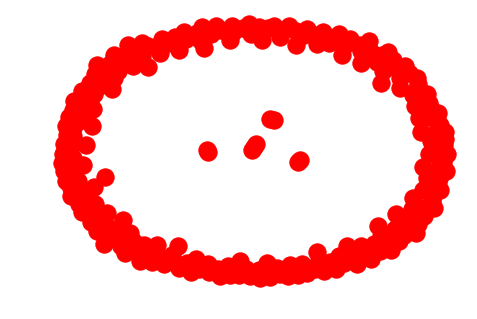

In [122]:
nx.draw(master_graph)

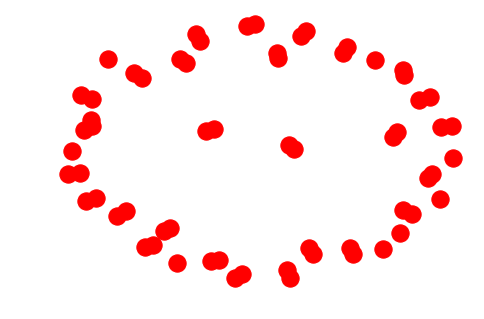

In [135]:
nx.draw(master_graph)

In [140]:
import pickle
with open('../data/neo4j_grpby.pkl', 'wb') as fl:
    pickle.dump(actors_filmography_group, fl)

In [149]:
stop = 3
my_neo_dfs = []
for i, film in enumerate(actors_filmography_group):
    my_neo_dfs.append(film[1])
    if stop == 3:
        break
    stop += 1

In [161]:

for act in actors_filmography_group:
    r = act[1]
    

KeyboardInterrupt: 

In [162]:
r

,cast_id,character,credit_id,gender,id_actor,movie,name,order,profile_path,genres,...,overview,popularity,poster_path,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average
491017,46.0,Male Raver,57ce5c3f92514160ce0010df,0.0,1469243.0,303858,Daniel K. Isaac,37.0,None,"[{'id': 53, 'name': 'Thriller'}]",...,Financial TV host Lee Gates and his producer P...,11.953822,/4BKptydRqLY9dQoAghJJJmrJuwR.jpg,2016-05-12,93282604.0,98.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Not every conspiracy is a theory.,Money Monster,6.5


In [152]:
neo_concat

,cast_id,character,credit_id,gender,id_actor,movie,name,order,profile_path,genres,...,overview,popularity,poster_path,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average
0,17.0,Superintendent,52fe47039251416c7508b233,0.0,66773.0,17082,\tCheung Chi-Sing,12.0,None,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",...,A police sniper teams up with a hot-headed roo...,3.04845,/wzzaD9L3kCCJEN97z4T3qnl7xdm.jpg,2009-03-24,0.0,90.0,"[{'iso_639_1': 'cn', 'name': '广州话 / 廣州話'}, {'i...",NaN,The Sniper,5.9


In [163]:
actors_and_movie_info_df.head()

,cast_id,character,credit_id,gender,id_actor,movie,name,order,profile_path,genres,...,overview,popularity,poster_path,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average
0,14.0,Woody (voice),52fe4284c3a36847f8024f95,2.0,31.0,862,Tom Hanks,0.0,/pQFoyx7rp09CJTAb932F2g8Nlho.jpg,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",...,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,Toy Story,7.7
1,15.0,Buzz Lightyear (voice),52fe4284c3a36847f8024f99,2.0,12898.0,862,Tim Allen,1.0,/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",...,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,Toy Story,7.7
2,16.0,Mr. Potato Head (voice),52fe4284c3a36847f8024f9d,2.0,7167.0,862,Don Rickles,2.0,/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",...,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,Toy Story,7.7
3,17.0,Slinky Dog (voice),52fe4284c3a36847f8024fa1,2.0,12899.0,862,Jim Varney,3.0,/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",...,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,Toy Story,7.7
4,18.0,Rex (voice),52fe4284c3a36847f8024fa5,2.0,12900.0,862,Wallace Shawn,4.0,/oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",...,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,Toy Story,7.7


In [173]:
actors_and_movie_info_df.head(100).to_csv('../data/actors_and_movies.neo4j_sm.csv', na_rep='N/A', index=False,
                               columns=['name', 'id_actor', 'profile_path', 'character', 'movie',  'id_movie',
                                        'genres', 'homepage', 'original_title', 'popularity', 'poster_path',
                                        'title', 'vote_average'])

In [171]:
actors_and_movie_info_df.columns

Index(['cast_id', 'character', 'credit_id', 'gender', 'id_actor', 'movie',
       'name', 'order', 'profile_path', 'genres', 'homepage', 'id_movie',
       'original_title', 'overview', 'popularity', 'poster_path',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'tagline',
       'title', 'vote_average'],
      dtype='object')

array([' ', "'", ',', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ':', 'A', 'C', 'D', 'F', 'H', 'M', 'R', 'S', 'T', 'V', 'W', '[',
       ']', 'a', 'c', 'd', 'e', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'r',
       's', 't', 'u', 'v', 'y', '{', '}'], dtype=object)